In [97]:
import pandas as pd
import re # regex module from python 
from pathlib import Path #python module to navigate into the Filesystem
import fitz # to parse PDF (PyMuPDF package)
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

In [3]:
#Load the database

articledb = pd.read_csv('C:/Users/pjcun/Dropbox/M2 AI4PH/NLP/NLP_LitReview/results/Familly NICU.csv')

I use the package PyMuPDF to extract the raw text from the .pdf article. (this article is a comparison of different solution existing : https://arxiv.org/html/2410.09871v1).

After a first raw text extraction, we'll try to identify the body of the article using RegEx. The isolation of the body of text is essential for the understanding of the article topics.


In [4]:
# creation of an extraction function with fitz

def extract_pdf_text(path):
    doc = fitz.open(path)
    texts = []
    for page in doc: # basic extraction page after page
        txt = page.get_text("text") 
        texts.append(txt)
    doc.close()
    full_text = "\n".join(texts)
    return full_text


In [17]:
#Listing of pdf file from the path results\Full article
dossier = Path("Full article/")
pdf_name = [f.name for f in dossier.iterdir()]

In [ ]:
pdf_strip = []

for art in range(len(pdf_name)):
    pdf_strip.append(extract_pdf_text(f'Full article/{pdf_name[art]}'))


In [31]:
# create a function which extract the body of the text
# we use Regex to try to limit the body of the text

def body_extraction(text):
    
    text = text.replace("\u00a0", " ")  # unbreakable space
    text = re.sub(r"[ \t]+", " ", text) # horizontal space normalisation
    text = re.sub(r"\n{3,}", "\n\n", text) # vertical space normalisation
    lines = [l.strip() for l in text.splitlines()]
    lines = [l for l in lines if l]  # remove empty line
  
  
    intro_pat = re.compile(r"^(introduction|background)$", re.IGNORECASE)
    stop_pats = [
        re.compile(r"^(references|bibliography|literature cited)$", re.IGNORECASE),
        re.compile(r"^(acknowledg(e)?ments?)$", re.IGNORECASE),
        re.compile(r"^(supplementary( material)?|appendix|annexe[s]?)$", re.IGNORECASE),
    ]

    in_body = False
    kept = []

    for line in lines: # find beginning
        if not in_body and intro_pat.match(line):
            in_body = True
            kept.append(line)
            continue

        if in_body: # find the end
            if any(p.match(line) for p in stop_pats):
                break
            kept.append(line)

    if not kept: # kept the text from the beginning if the is no introcution find
        kept = lines

    body_text = "\n".join(kept)
    return body_text


In [36]:
body = []

for be in range(len(pdf_strip)):
    body.append(body_extraction(pdf_strip[be]))

In [42]:
body

["Introduction\nBackground\nStroke is a highly prevalent public health concern, and\nthe leading cause of death and disability among adults in\ndeveloped countries [1, 2]. In the USA alone, stroke has\nan annual incidence of approximately 795,000, and is as-\nsociated with an estimated 34 billion dollar cost from\nhealth care services, medications, and missed days of\nwork [1]. A stroke is often a devastating life-altering\nevent for both patients and their family/friend caregivers\n[3–5]. Stroke occurs without warning and may result\nnot only in death or profound disability but also sub-\nstantial emotional trauma for both patients and care-\ngivers [5, 6]. Although advances in endovascular and\nneurocritical care approaches to stroke treatment and\nrecovery have substantially increase the number of survi-\nvors, there remains a need to develop treatments to ad-\ndress the emotional sequelae associated with the stroke\nand subsequent hospitalization for both patients and\ntheir inform

After a quick look on the extracted text, we can do improvement with simple RegEx:

- Removing the pattern like *particu-\nlarly, irrita-\nbility, ... * which is quite frequent and represent are word separated on two line.
- Removing the pattern *\n* whic is not really informative.
- Removing the reference which are beetween square brakets
- Removing URL & DOI



In [49]:
def regex_corrector(text):
    text =  re.sub(r"-\n(\w+)", r"\1", text) # remove -\n
    text = re.sub(r"\n", " ", text) # remove \n 
    text =  re.sub(r"\[\s*\d+(?:\s*[-,]\s*\d+)*\s*\]", "", text) # remove [1], [3,4,5], [12–14] ...
    text = re.sub(r"https?://\S+|www\.\S+", "", text) # URL
    text = re.sub(r"\bdoi:\s*\S+", "", text, flags=re.IGNORECASE) # doi: DOI:
    text = re.sub(r"\b10\.\d{4,9}/\S+\b", "", text) # 10.xxx\

    return text


In [50]:
for be in range(len(body)):
    body[be] = regex_corrector(body[be])

In [51]:
body

["Introduction Background Stroke is a highly prevalent public health concern, and the leading cause of death and disability among adults in developed countries . In the USA alone, stroke has an annual incidence of approximately 795,000, and is associated with an estimated 34 billion dollar cost from health care services, medications, and missed days of work . A stroke is often a devastating life-altering event for both patients and their family/friend caregivers [3–5]. Stroke occurs without warning and may result not only in death or profound disability but also substantial emotional trauma for both patients and caregivers . Although advances in endovascular and neurocritical care approaches to stroke treatment and recovery have substantially increase the number of survivors, there remains a need to develop treatments to address the emotional sequelae associated with the stroke and subsequent hospitalization for both patients and their informal caregivers. Rates of clinically significa

In [ ]:
# remove the stop words with scikit kearn

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def stp_wrd(text):
    filtered = [w for w in text.lower().split() if w not in ENGLISH_STOP_WORDS]
    return ' '.join(filtered)

for be in range(len(body)):
    body[be] = stp_wrd(body[be])

i'd like to do a thematic analysis of theses article using AI models derived from transformers (BERT). The BERTopic approach seems to be interesting to do this kind of analysis. (92 arcicles in 2025 using BERTopic in PubMed)

i'll do an embeding foe each article' raw text and then use a clustering algorithm to group the articles into themes.

The PubMedBERT Embeddings model (https://huggingface.co/NeuML/pubmedbert-base-embeddings) ,seems to be a good choice for my medical corpus of articles text.


In [63]:
body = pd.Series(body)

In [85]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer


embedding_model = SentenceTransformer("NeuML/pubmedbert-base-embeddings")

embeddings = embedding_model.encode(body, show_progress_bar=True)

topic_model = BERTopic(
    embedding_model=embedding_model,
    min_topic_size=4, # we had few article, so i give a low limit value
    verbose=True,
    calculate_probabilities=True
)

topics, probs = topic_model.fit_transform(body, embeddings)

topic_model.get_topic_info()


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-18 12:28:54,440 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-18 12:28:54,470 - BERTopic - Dimensionality - Completed ✓
2026-01-18 12:28:54,471 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-18 12:28:54,476 - BERTopic - Cluster - Completed ✓
2026-01-18 12:28:54,479 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-18 12:28:54,528 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,3,-1_family_decision_families_making,"[family, decision, families, making, members, ...",[introduction million cases traumatic brain in...
1,0,12,0_patients_icu_caregivers_anxiety,"[patients, icu, caregivers, anxiety, pics, dep...",[introduction admission neurological intensive...
2,1,11,1_care_patients_patient_palliative,"[care, patients, patient, palliative, ccm, tea...",[research article improvement quality metrics ...


- Topic -1 (3 docs) : outliers, non intégrés dans un topic stable, ignorable pour la plupart des analyses.

- Topic 0 (12 docs) : soins en réanimation / ICU, anxiété des proches et PICS
Mots : patients, icu, caregivers, anxiety, pics, depression…
Les représentative docs parlent d’admission en réanimation neurologique, etc.

- Topic 1 (11 docs) : soins palliatifs / qualité des soins / équipes de soins
Mots : care, patients, patient, palliative, team, quality metrics…

In [89]:
fig = topic_model.visualize_barchart(top_n_topics=2)
fig.show()

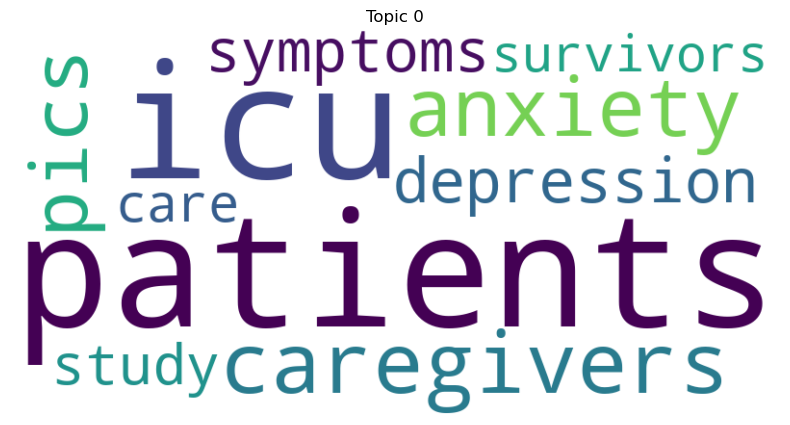

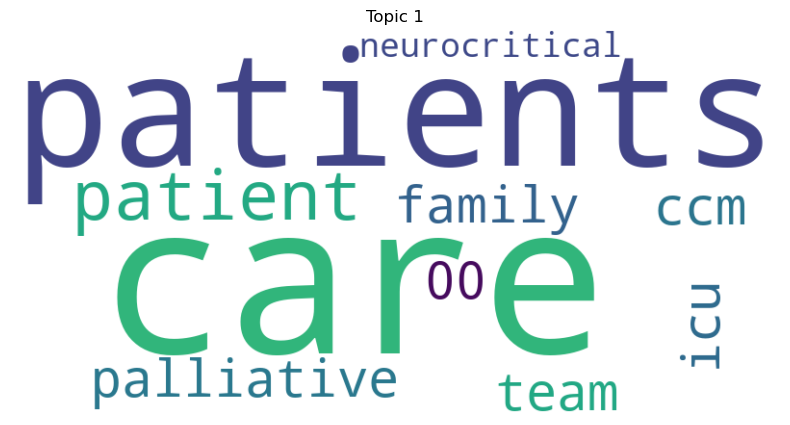

In [98]:
def plot_wordcloud_from_topic_terms(topic_model, topic_id, top_n=50):
    terms = topic_model.get_topic(topic_id)  # list of (word, score)
    if not terms:
        print(f"No terms for topic {topic_id}")
        return

    freqs = {w: s for w, s in terms[:top_n]}

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate_from_frequencies(freqs)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_id}")
    plt.show()

plot_wordcloud_from_topic_terms(topic_model, 0)
plot_wordcloud_from_topic_terms(topic_model, 1)